In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
dat = pd.read_csv('semi_and_final_features.csv')
dat.columns = ['Account_ID', 'EVENT_ID', 'TRANSACTION_COUNT', 'STATUS_ID',
       'INPLAY_BET', 'AVG_BET_SIZE', 'MAX_BET_SIZE', 'MIN_BET_SIZE',
       'STDEV_BET_SIZE']

In [67]:
dat.head(10)

,Account_ID,EVENT_ID,TRANSACTION_COUNT,STATUS_ID,INPLAY_BET,AVG_BET_SIZE,MAX_BET_SIZE,MIN_BET_SIZE,STDEV_BET_SIZE
0,1000002,101187238,6,C,N,76.192150,189.690000,7.587600,76.803761
1,1000002,101187238,2,S,N,278.844300,379.380000,178.308600,142.178950
2,1000002,101187238,43,S,Y,142.274117,758.760000,3.793800,190.065261
3,1000002,101187943,8,C,N,169.758000,471.550000,3.772400,188.339556
4,1000002,101187943,69,S,Y,182.086641,692.838984,3.772400,150.043870
5,1000002,101191295,2,S,N,118.650076,192.520000,44.780152,104.467848
6,1000002,101191295,11,S,Y,68.138079,248.350800,11.377932,79.751261
7,1000003,101187238,1,S,N,20.000000,20.000000,20.000000,0.000000
8,1000003,101187943,1,S,N,50.000000,50.000000,50.000000,0.000000
9,1000004,101187943,1,S,N,943.100000,943.100000,943.100000,0.000000


In [14]:
dat.Account_ID.nunique()

13087

In [4]:
dat.EVENT_ID.value_counts()

101187238    20100
101187943    19407
101191295    13563
dtype: int64

In [5]:
dat.STATUS_ID.value_counts()

S    38020
C    13591
L     1459
dtype: int64

In [4]:
submit = pd.read_csv('sample_submission_bet_size.csv')

In [5]:
submit.columns = ['Account_ID', 'Prediction']

In [6]:
submit.head()

,Account_ID,Prediction
0,1004240,19027.790500
1,1009742,530423.584971
2,1003908,2264.014397
3,1020888,657.100800
4,1010074,2709.854433


In [7]:
submit.shape

(7374, 2)

In [8]:
final = dat.loc[dat.Account_ID.isin(submit.Account_ID)]

In [9]:
final_by_account = final.groupby('Account_ID')

In [131]:
event = final_by_account['EVENT_ID'].nunique()

In [133]:
# how many of them have bet on how many events
event.value_counts()

3    2990
2    2302
1    2082
dtype: int64

In [10]:
import glob

In [11]:
filenames = glob.glob('Datathon*.csv')

In [227]:
filenames

['DatathonWCDataGames1-10.csv',
 'DatathonWCDataGames11-20.csv',
 'DatathonWCDataGames21-30.csv',
 'DatathonWCDataGames31-40.csv',
 'DatathonWCDataGamesQTRFinals.csv']

In [363]:
pre_dat = pd.DataFrame({})
for ind, filename in enumerate(filenames):
    print(ind)
    tmp_dat = pd.read_csv(filename)
    pre_dat = pre_dat.append(tmp_dat)    
pre_dat.columns = ['BET_ID', 'BET_TRANS_ID', 'MATCH_BET_ID', 'ACCOUNT_ID',
       'COUNTRY_OF_RESIDENCE_NAME', 'PARENT_EVENT_ID', 'EVENT_ID', 'MATCH',
       'EVENT_NAME', 'EVENT_DT', 'OFF_DT', 'BID_TYP', 'STATUS_ID',
       'PLACED_DATE', 'TAKEN_DATE', 'SETTLED_DATE', 'CANCELLED_DATE',
       'SELECTION_NAME', 'PERSISTENCE_TYPE', 'BET_PRICE', 'PRICE_TAKEN',
       'INPLAY_BET', 'BET_SIZE', 'PROFIT_LOSS']
peek_dat = pd.read_csv('DSMDatathon_samplefile.txt', sep='\t')
pre_dat = peek_dat.append(pre_dat)

0
1

/Users/feizhan/miniconda/envs/py3_env/lib/python3.4/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)
/Users/feizhan/miniconda/envs/py3_env/lib/python3.4/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (14,16) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)



2
3
4


In [364]:
pre_dat.loc[:, 'BID_TYP'] = pre_dat.BID_TYP.str.strip(' ')
pre_dat.loc[:, 'STATUS_ID'] = pre_dat.STATUS_ID.str.strip(' ')
# correct the profit loss
c1 = ((pre_dat.BID_TYP == 'B') & (pre_dat.PROFIT_LOSS > 0))
c2 = ((pre_dat.BID_TYP == 'B') & (pre_dat.PROFIT_LOSS < 0))
c3 = ((pre_dat.BID_TYP == 'L') & (pre_dat.PROFIT_LOSS > 0))
c4 = ((pre_dat.BID_TYP == 'L') & (pre_dat.PROFIT_LOSS < 0))
pre_dat.loc[c1.values, 'correct_profit_loss'] = pre_dat.loc[c1.values, 'BET_SIZE'] * (pre_dat.loc[c1.values, 'PRICE_TAKEN'] -1)
pre_dat.loc[c2.values, 'correct_profit_loss'] = - pre_dat.loc[c2.values, 'BET_SIZE']
pre_dat.loc[c3.values, 'correct_profit_loss'] = pre_dat.loc[c3.values, 'BET_SIZE']
pre_dat.loc[c4.values, 'correct_profit_loss'] = - pre_dat.loc[c4.values, 'BET_SIZE'] * (pre_dat.loc[c4.values, 'PRICE_TAKEN'] -1)

In [42]:
pre_dat = pre_dat.loc[pre_dat.ACCOUNT_ID.isin(submit.Account_ID)]

In [319]:
pre_dat = pre_dat.loc[(pre_dat.STATUS_ID == 'S').values]

In [365]:
pre_dat_by_accountid = pre_dat.groupby('ACCOUNT_ID')

In [366]:
pre_dat_bet_freq = pre_dat_by_accountid['EVENT_ID'].apply(lambda x: len(set(x)))

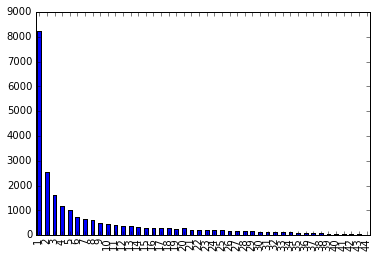

In [383]:
pre_dat_bet_freq.value_counts().sort_index().plot(kind='bar', legend=False)

In [378]:
subset = pre_dat.loc[pre_dat.ACCOUNT_ID.isin(submit.Account_ID)]

In [379]:
subset_by_accountid = subset.groupby('ACCOUNT_ID')

In [380]:
subset_bet_freq = subset_by_accountid['EVENT_ID'].apply(lambda x: len(set(x)))

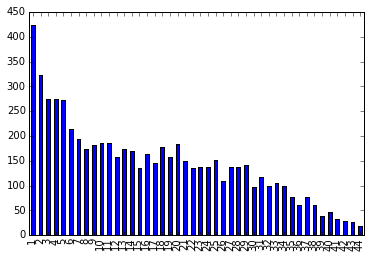

In [384]:
subset_bet_freq.value_counts().sort_index().plot(kind='bar', legend=False)

In [385]:
final_bet_freq = final_by_account['EVENT_ID'].apply(lambda x: len(set(x)))

In [387]:
final_bet_freq.name = 'final_bet_freq'

In [394]:
subset_bet_freq = pd.concat([subset_bet_freq, final_bet_freq], axis=1)

In [395]:
subset_bet_freq.head()

,EVENT_ID,final_bet_freq
1000002,26,3
1000004,12,1
1000005,8,2
1000010,24,2
1000014,1,3


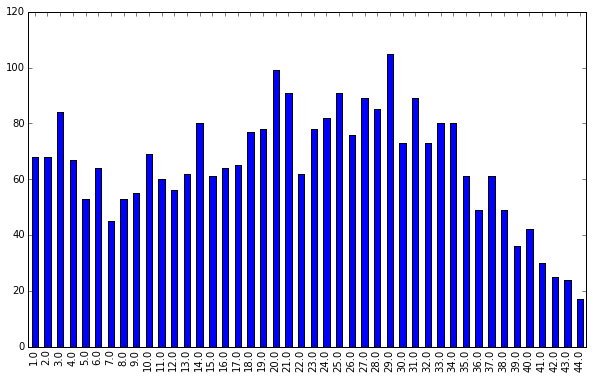

In [400]:
plt.figure(figsize=(10, 6))
subset_bet_freq.loc[(subset_bet_freq.final_bet_freq == 3).values, 'EVENT_ID'].value_counts().sort_index().plot(kind='bar', legend=False)

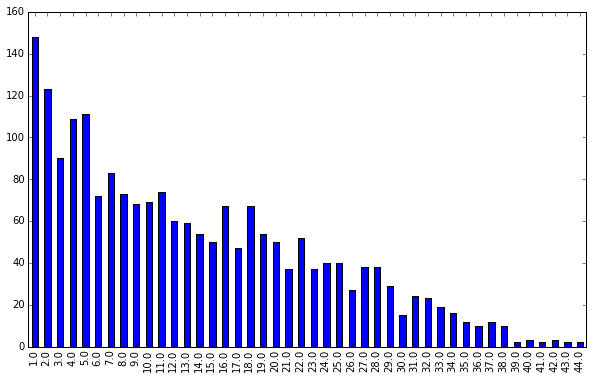

In [401]:
plt.figure(figsize=(10, 6))
subset_bet_freq.loc[(subset_bet_freq.final_bet_freq == 2).values, 'EVENT_ID'].value_counts().sort_index().plot(kind='bar', legend=False)

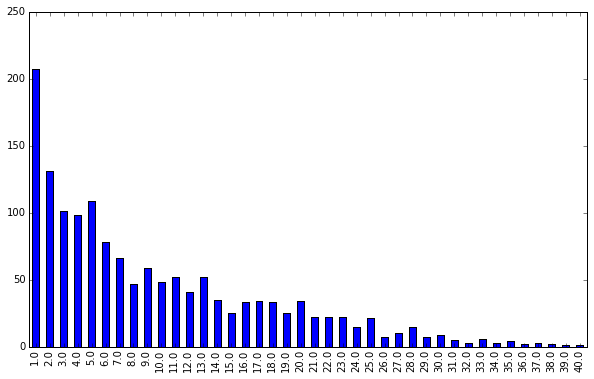

In [402]:
plt.figure(figsize=(10, 6))
subset_bet_freq.loc[(subset_bet_freq.final_bet_freq == 1).values, 'EVENT_ID'].value_counts().sort_index().plot(kind='bar', legend=False)

In [406]:
new_comers = submit.loc[~submit.Account_ID.isin(pre_dat.ACCOUNT_ID), 'Account_ID'].tolist()
new_comer_dat = dat.loc[dat.Account_ID.isin(new_comers)]

In [409]:
new_comer_dat.groupby('Account_ID')['EVENT_ID'].apply(lambda x: len(set(x))).value_counts()

1    594
2    281
3    114
dtype: int64

In [411]:
subset_by_accountid_eventid = subset.groupby(['ACCOUNT_ID', 'EVENT_ID'])

In [413]:
subset_perf = subset_by_accountid_eventid['correct_profit_loss'].sum()

In [417]:
is_subset_win = subset_perf.groupby(level=0).apply(lambda x: x > 0)

In [418]:
is_subset_win.name = 'is_win'

In [419]:
is_subset_win = is_subset_win.reset_index()

In [422]:
subset_always_win = is_subset_win.groupby('ACCOUNT_ID')['is_win'].apply(all)

In [423]:
subset_always_win.value_counts()

False    5975
True      410
dtype: int64

In [424]:
# do they bet often? 
subset.loc[subset.ACCOUNT_ID.isin(subset_always_win.loc[subset_always_win.values].index.tolist())].groupby('ACCOUNT_ID')['EVENT_ID'].apply(lambda x: len(set(x))).value_counts()

1     176
2      89
3      54
4      28
5      24
6       9
7       5
9       5
8       4
11      4
10      3
12      2
17      2
26      1
15      1
18      1
19      1
40      1
dtype: int64

In [428]:
subset_always_win = subset_always_win.loc[submit.Account_ID]

In [430]:
subset_always_win = subset_always_win.fillna(False)

In [432]:
subset_always_win.name = 'Prediction'
subset_always_win.index.name = 'Account_ID'
subset_always_win = subset_always_win.reset_index()

In [435]:
subset_always_win.loc[:, 'Prediction'] = subset_always_win.Prediction.apply(int)

In [437]:
subset_always_win.to_csv('always_wins.csv', index=False)

In [439]:
# now I wanna get the faith each one got on the four teams
def loyalty_checker(df, country='Australia'):
    is_playing = df.MATCH.str.contains(country)
    df = df.loc[is_playing.values]
    is_for = ((df.SELECTION_NAME == country) & (df.BID_TYP == 'B')) | ((df.SELECTION_NAME != country) & (df.BID_TYP == 'L'))
    return df.loc[is_for].groupby('MATCH')['BET_SIZE'].sum().mean()                                                                                               

In [483]:
res = subset_by_accountid[['SELECTION_NAME', 'BID_TYP', 'BET_SIZE', 'MATCH']].apply(loyalty_checker, country='India')

In [470]:
faith_table = pd.DataFrame({})

In [484]:
res.name = 'India'
res = res.reset_index()

In [469]:
res.head()

,ACCOUNT_ID,South Africa
0,1000002,1881.143613
1,1000004,367.469625
2,1000005,5058.250000
3,1000010,494.751600
4,1000014,100.000000


In [485]:
faith_table = pd.concat([faith_table, res.iloc[:, 1]], axis=1)

In [487]:
faith_table = faith_table.fillna(0)
faith_table.head()

,ACCOUNT_ID,South Africa,Australia,New Zealand,India
0,1000002,1881.143613,2900.5274,1963.477738,2608.7174
1,1000004,367.469625,37.5098,0.000000,0.0000
2,1000005,5058.250000,1103.1780,0.000000,13643.4375
3,1000010,494.751600,0.0000,969.700000,795.2424
4,1000014,100.000000,0.0000,0.000000,0.0000


In [488]:
sim_dat = dat.loc[(dat.Account_ID.isin(faith_table.ACCOUNT_ID) & dat.STATUS_ID.isin(['S'])).values]

In [491]:
sim_dat.loc[:, 'total'] = sim_dat.TRANSACTION_COUNT * sim_dat.AVG_BET_SIZE

/Users/feizhan/miniconda/envs/py3_env/lib/python3.4/site-packages/pandas/core/indexing.py:249: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/feizhan/miniconda/envs/py3_env/lib/python3.4/site-packages/pandas/core/indexing.py:415: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [492]:
sim_dat1 = sim_dat[['Account_ID', 'EVENT_ID', 'total']]

In [495]:
sim_dat1 = pd.merge(sim_dat1, faith_table, left_on='Account_ID', right_on='ACCOUNT_ID')

In [496]:
sim_dat1.head()

,Account_ID,EVENT_ID,total,ACCOUNT_ID,South Africa,Australia,New Zealand,India
0,1000002,101187238,557.688600,1000002,1881.143613,2900.5274,1963.477738,2608.7174
1,1000002,101187238,6117.787035,1000002,1881.143613,2900.5274,1963.477738,2608.7174
2,1000002,101187943,12563.978200,1000002,1881.143613,2900.5274,1963.477738,2608.7174
3,1000002,101191295,237.300152,1000002,1881.143613,2900.5274,1963.477738,2608.7174
4,1000002,101191295,749.518864,1000002,1881.143613,2900.5274,1963.477738,2608.7174


In [498]:
won_first = (sim_dat1.EVENT_ID == 101187238) & (sim_dat1.loc[:, 'New Zealand'] > sim_dat1.loc[:, 'South Africa'])  
lost_first = (sim_dat1.EVENT_ID == 101187238) & (sim_dat1.loc[:, 'New Zealand'] < sim_dat1.loc[:, 'South Africa'])
no_first = (sim_dat1.EVENT_ID == 101187238) & (sim_dat1.loc[:, 'New Zealand'] == sim_dat1.loc[:, 'South Africa'])
won_second = (sim_dat1.EVENT_ID == 101187943) & (sim_dat1.loc[:, 'Australia'] > sim_dat1.loc[:, 'India'])  
lost_second = (sim_dat1.EVENT_ID == 101187943) & (sim_dat1.loc[:, 'Australia'] < sim_dat1.loc[:, 'India'])
no_second = (sim_dat1.EVENT_ID == 101187943) & (sim_dat1.loc[:, 'Australia'] == sim_dat1.loc[:, 'India'])
won_third = (sim_dat1.EVENT_ID == 101191295) & (sim_dat1.loc[:, 'Australia'] > sim_dat1.loc[:, 'New Zealand'])  
lost_third = (sim_dat1.EVENT_ID == 101191295) & (sim_dat1.loc[:, 'Australia'] < sim_dat1.loc[:, 'New Zealand'])
no_third = (sim_dat1.EVENT_ID == 101191295) & (sim_dat1.loc[:, 'Australia'] == sim_dat1.loc[:, 'New Zealand'])

In [501]:
sim_dat1.loc[won_first.values, 'result'] = sim_dat1.loc[won_first.values, 'total']
sim_dat1.loc[lost_first.values, 'result'] = - sim_dat1.loc[lost_first.values, 'total']
sim_dat1.loc[no_first.values, 'result'] = 0
sim_dat1.loc[won_second.values, 'result'] = sim_dat1.loc[won_second.values, 'total']
sim_dat1.loc[lost_second.values, 'result'] = - sim_dat1.loc[lost_second.values, 'total']
sim_dat1.loc[no_second.values, 'result'] = 0
sim_dat1.loc[won_third.values, 'result'] = sim_dat1.loc[won_third.values, 'total']
sim_dat1.loc[lost_third.values, 'result'] = - sim_dat1.loc[lost_third.values, 'total']
sim_dat1.loc[no_second.values, 'result'] = 0

In [502]:
sim_dat1.head()

,Account_ID,EVENT_ID,total,ACCOUNT_ID,South Africa,Australia,New Zealand,India,result
0,1000002,101187238,557.688600,1000002,1881.143613,2900.5274,1963.477738,2608.7174,557.688600
1,1000002,101187238,6117.787035,1000002,1881.143613,2900.5274,1963.477738,2608.7174,6117.787035
2,1000002,101187943,12563.978200,1000002,1881.143613,2900.5274,1963.477738,2608.7174,12563.978200
3,1000002,101191295,237.300152,1000002,1881.143613,2900.5274,1963.477738,2608.7174,237.300152
4,1000002,101191295,749.518864,1000002,1881.143613,2900.5274,1963.477738,2608.7174,749.518864


In [503]:
imagined_res = sim_dat1.groupby('Account_ID')['result'].sum()

In [507]:
imagined_res = imagined_res.loc[submit.Account_ID]

In [512]:
imagined_res = imagined_res.fillna(-2.4e7)

In [513]:
imagined_res.index.name = 'Account_ID'
imagined_res.name = 'Prediction'
imagined_res = imagined_res.reset_index()

In [515]:
imagined_res.head()

,Account_ID,Prediction
0,1004240,-9203.463318
1,1009742,-190596.275105
2,1003908,-613.848469
3,1020888,0.000000
4,1010074,0.000000


In [517]:
imagined_res.to_csv('imagined_res.csv', index=False)

In [296]:
# need a function to calculate auc
def cal_auc(evaluation, known_fact):
    length = known_fact.shape[0]
    assert evaluation.shape[0] == length, 'should equal long'
    num_kp = known_fact.fact.sum()
    num_kn = known_fact.shape[0] - num_kp
    kps = known_fact.loc[(known_fact.fact == 1).values, 'ACCOUNT_ID']
    kns = known_fact.loc[(known_fact.fact == 0).values, 'ACCOUNT_ID']
    auc_pairs = pd.DataFrame({})
    for ind in range(length):
        num_fp = evaluation.iloc[ind:].ACCOUNT_ID.isin(kns).sum()
        num_tp = evaluation.iloc[ind:].ACCOUNT_ID.isin(kps).sum()
        auc_pair = pd.DataFrame({
            'fpr': [num_fp/num_kn],
            'tpr': [num_tp/num_kp]})
        auc_pairs = auc_pairs.append(auc_pair)
    return auc_pairs, auc_pairs.tpr.sum() / auc_pairs.shape[0]

In [ ]:
# need to create "train", validation sets

In [243]:
pre_dat_by_eventid_accountid = pre_dat.groupby(['EVENT_ID', 'ACCOUNT_ID'])

In [518]:
example = pre_dat.groupby(['ACCOUNT_ID', 'EVENT_ID'])['correct_profit_loss'].sum()

In [520]:
example.sort_index()

ACCOUNT_ID  EVENT_ID 
682         101092958             NaN
1011        101092958      -49.495000
1534        101092958       -6.929300
1887        101092958      397.939800
2155        101092958      -49.495000
2166        101092958       -3.959600
2627        101092958      -49.495000
2784        101092958     -247.475000
3614        101092958             NaN
3773        101092958     -250.345710
3877        101092958      -10.690920
4703        101092958             NaN
4961        101092958      -39.596000
5281        101092958             NaN
5500        101092958       41.575800
5586        101092958       -3.959600
5803        101092958             NaN
6229        101092958      439.515600
7245        101092958             NaN
7985        101092958             NaN
8028        101092958       -9.899000
8273        101092958      -58.206120
8621        101092958    -9780.721007
8748        101092958     -265.293200
9362        101092958             NaN
9562        101092958       

In [244]:
result_set = pre_dat_by_eventid_accountid['correct_profit_loss'].sum()

In [245]:
result_set.name = 'profit_loss_sum'

In [246]:
result_set = result_set.reset_index()

In [247]:
result_set.head()

,EVENT_ID,ACCOUNT_ID,profit_loss_sum
0,101092958,1011,-49.4950
1,101092958,1534,-6.9293
2,101092958,1887,397.9398
3,101092958,2155,-49.4950
4,101092958,2166,-3.9596


In [248]:
event_ids = result_set.EVENT_ID.unique()

In [254]:
event_ids

array([101092958, 101093076, 101093194, 101093312, 101128269, 101128387,
       101149398, 101149516, 101149634, 101149870, 101149988, 101150106,
       101150224, 101150348, 101150480, 101150598, 101150716, 101150834,
       101150952, 101151090, 101151214, 101151342, 101151486, 101151606,
       101151748, 101151878, 101152014, 101152132, 101152275, 101152395,
       101152576, 101152715, 101152836, 101152954, 101153072, 101153190,
       101153308, 101153426, 101153544, 101153662, 101183237, 101183757,
       101183885, 101184013])

In [250]:
from sklearn.cross_validation import KFold

In [303]:
kf = KFold(44, n_folds=5)

In [318]:
auc_pairs_list = []
auc_list = []
for ind, (train_ind, test_ind) in enumerate(kf):
    print(ind)
    train_eventid = event_ids[train_ind]
    test_eventid = event_ids[test_ind]
    test_dat = pre_dat.loc[pre_dat.EVENT_ID.isin(test_eventid)]
    truth = (test_dat.groupby('ACCOUNT_ID')['correct_profit_loss'].sum() > 0).apply(lambda x: int(x))
    truth.name = 'fact'
    truth = truth.reset_index()
    train_dat = pre_dat.loc[pre_dat.EVENT_ID.isin(train_eventid)]
    pred = train_dat.groupby('ACCOUNT_ID')['correct_profit_loss'].size()
    pred = pred.loc[truth.ACCOUNT_ID]
    pred.sort()
    pred.name = 'points'
    pred = pred.reset_index()
    auc_pairs, auc = cal_auc(pred, truth)
    auc_pairs_list.append(auc_pairs)
    auc_list.append(auc)

0
1
2
3
4


In [317]:
auc_list

[0.5371357735162009,
 0.49576178344484889,
 0.51381314963185432,
 0.50732651653661531,
 0.49965251500175062]

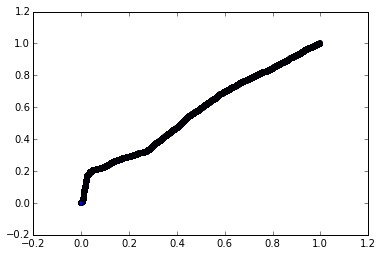

In [315]:
i = 0
plt.scatter(auc_pairs_list[i].fpr, auc_pairs_list[i].tpr)

In [403]:
220*52/12

953.3333333333334